# Plotting of Evaluation Results

*Here, use seaborn, which calculates a bootstrapped 95% CI, which looks nicer and more narrow than
with matplotlib*

You need to run `aggregator.py` first. Specify which results to aggregate in `settings.py`.

These are the results for running the algorithms on the large GTS CE network and collecting metrics 
every 100 time steps. 30% ingress nodes (config `hc_0.3+`).
Seems like `hc_0.3` is the same, but the decisions aren't recorded (also not needed here).

Goal: Show that they work on a very large network and lead to stable results.
In particular, the percentage of successful flows doesn't drop and the end-to-end delay doesn't increase over time.

## Definition of plotting functions & settings

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ing_perc = '0.3'
# result_dir = 'transformed_0-49_perc-flows'
result_dir = f'transformed_dfn_{ing_perc}_distr'
result_dir_bsp = f'transformed_dfn_{ing_perc}_bsp'
# configs = ['hc_0.3+']
configs = ['hc', 'lnc']
# network = 'gts_ce_149.graphml'
network = 'dfn_58.graphml'

labels = ['GCASP', 'SBC', 'BSP', 'BSP+']

sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})

In [2]:
def plot_successful(df, labels):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})

    # successful_flows for the gts ce network
    df_successful = df[df['Metric'] == 'perc_successful_flows']
    print(df_successful['Algorithm'].unique())

    # *100 to convert to percent
    sns.lineplot(df_successful['Time'], df_successful['Value'], hue=df_successful['Algorithm'], ax=ax,
                 err_style='bars', err_kws={'capsize': 4},
                 style=df_successful['Algorithm'], markers=True, markersize=9, legend=False)

    ax.set_xlabel('Time')
    ax.set_ylabel('Successful Flows [%]')
    # ax.set_ylim(0, 1.05)
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend(labels=labels)

    plt.tight_layout()
    network_name = network.replace('.graphml', '')
    fig.savefig(f'plots/time_{network_name}_{config}_flows.pdf')

In [3]:
def plot_delay(df, labels):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})

    df_delay = df[df['Metric'] == 'avg_end2end_delay_of_processed_flows']
    print(df_delay['Algorithm'].unique())

    sns.lineplot(df_delay['Time'], df_delay['Value'], hue=df_delay['Algorithm'], ax=ax,
                 err_style='bars', err_kws={'capsize': 4},
                 style=df_delay['Algorithm'], markers=True, markersize=9, legend=False)

    ax.set_xlabel('Time')
    ax.set_ylabel('Avg. End-to-end Delay [ms]')
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend(labels=labels)

    plt.tight_layout()
    network_name = network.replace('.graphml', '')
    fig.savefig(f'plots/time_{network_name}_{config}_delay.pdf')

In [4]:
def plot_load(df, load, labels):
    assert load == 'node' or load == 'link', "Specify whether to plot node or link load"
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.set(font_scale=1.1, style='white', rc={'lines.linewidth': 2})

    if load == 'node':
        df_load = df[df['Metric'] == 'avg_node_load']
    else:
        df_load = df[df['Metric'] == 'avg_link_load']
    print(df_load['Algorithm'].unique())

    sns.lineplot(df_load['Time'], df_load['Value']*100, hue=df_load['Algorithm'], ax=ax,
                 err_style='bars', err_kws={'capsize': 4},
                 style=df_load['Algorithm'], markers=True, markersize=9, legend=False)

    ax.set_xlabel('Time')
    if load == 'node':
        ax.set_ylabel('Avg. Node Utilization [%]')
    else:
        ax.set_ylabel('Avg. Link Utilization [%]')
    ax.tick_params(axis='both', direction='inout', length=5, bottom=True, left=True, right=True, top=True)
    plt.legend(labels=labels)

    plt.tight_layout()
    network_name = network.replace('.graphml', '')
    fig.savefig(f'plots/time_{network_name}_{config}_load_{load}.pdf')

## Plot results

Metric: flow
Config: hc
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
Config: lnc
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
Metric: delay
Config: hc
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
Config: lnc
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
Metric: load
Config: hc
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
Config: lnc
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']
['gpasp' 'spr2' 'bjointsp' 'bjointsp_recalc']


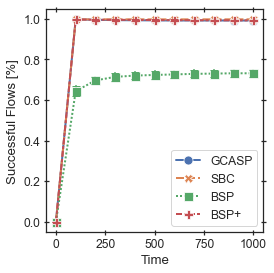

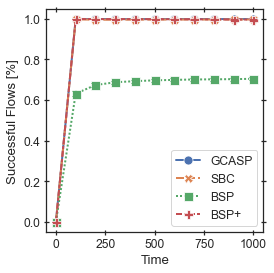

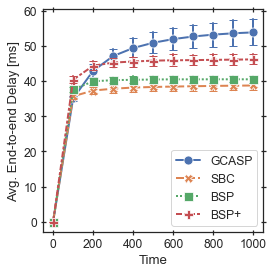

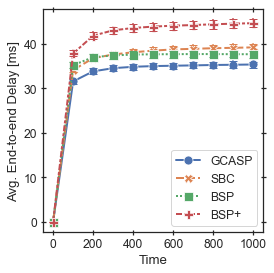

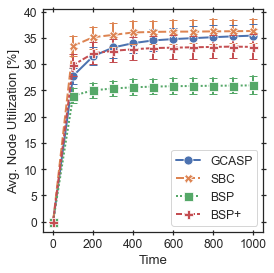

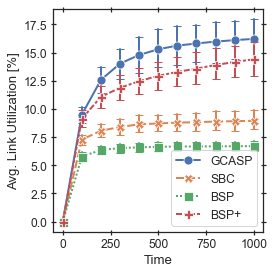

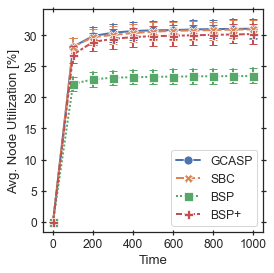

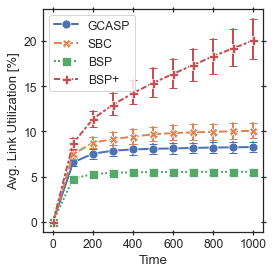

In [5]:
for metric in ['flow', 'delay', 'load']:
    print(f"Metric: {metric}", flush=True)
    for config in configs:
        print(f"Config: {config}", flush=True)
        df = pd.read_csv(f'{result_dir}/{config}/{network}/{metric}/t-metrics.csv',
                         names=['Time', 'Value', 'Metric', 'Algorithm'])
        df = df.append(pd.read_csv(f'{result_dir_bsp}/{config}/{network}/{metric}/t-metrics.csv',
                         names=['Time', 'Value', 'Metric', 'Algorithm']))
        df = df[df['Algorithm'] != 'spr1']

        if metric == 'flow':
            plot_successful(df, labels=labels)
        if metric == 'delay':
            plot_delay(df, labels=labels)
        if metric == 'load':
            plot_load(df, load='node', labels=labels)
            plot_load(df, load='link', labels=labels)